In [1]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from math import sqrt
from pandas import read_csv, DataFrame, concat
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer, GlobalAveragePooling1D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from datetime import datetime

In [2]:
# Reproducibility seed

seed_value = 7
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# --- Custom MinMaxScaler ---
class MinMaxScalerCustom:
    def fit(self, data):
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)

    def transform(self, data):
        return (data - self.min) / (self.max - self.min + 1e-8)

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

    def inverse_transform(self, data):
        return data * (self.max - self.min + 1e-8) + self.min

In [4]:
# --- Custom error metrics ---
def mean_squared_error_np(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mean_absolute_error_np(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [5]:
# --- Convert time series to supervised format ---
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

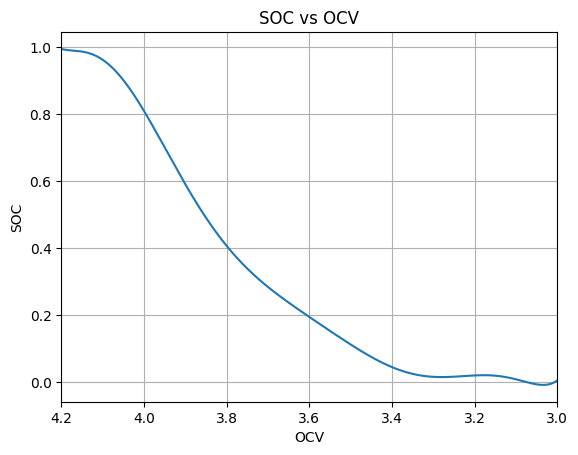

In [6]:
# --- Load and normalize data ---
file = os.path.join(os.getcwd(), 'socPol.csv')
dataset = read_csv(file)
values = dataset.values.astype('float32')

soc_raw = values[:, 0]
ocv_raw = values[:, 1]

plt.figure(1)
plt.plot(ocv_raw, soc_raw, linestyle='-')
plt.title('SOC vs OCV')
plt.xlabel('OCV')
plt.ylabel('SOC')
plt.xlim(4.2, 3.0)
plt.grid(True)

scaler = MinMaxScalerCustom()
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[3], axis=1, inplace=True)

In [7]:
# --- Split into train/test sets ---
values = reframed.values
n_train = int(len(values) * 0.75)
train, test = values[:n_train, :], values[n_train:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

In [8]:
# --- Reshape to 3D [samples, timesteps, features] ---
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [9]:
# --- Self-Attention Layer ---
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        Q = tf.matmul(inputs, self.Wq)
        K = tf.matmul(inputs, self.Wk)
        V = tf.matmul(inputs, self.Wv)

        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_scores /= tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        return tf.matmul(attention_weights, V)

In [10]:
# --- Callbacks ---
log_dir = os.path.join("logs/fit/", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)

In [12]:
# --- Model Definition ---
inputs = Input(shape=(train_x.shape[1], train_x.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = SelfAttention()(x)
x = GlobalAveragePooling1D()(x)
output = Dense(1)(x)

model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

plot_model(model, to_file='model_architecture_lstm.png', show_shapes=True, show_layer_names=True)
print("Model architecture saved to 'model_architecture_lstm_attentionlayer.png'")


Model architecture saved to 'model_architecture_lstm_attentionlayer.png'


In [13]:
# --- Train Model ---
history = model.fit(train_x, train_y, epochs=20, batch_size=64,
                    validation_data=(test_x, test_y),
                    callbacks=[tensorboard_cb, earlystop_cb, checkpoint_cb],
                    verbose=1)

Epoch 1/20
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0940 - mae: 0.2111

118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0362 - mae: 0.1208 - val_loss: 0.0038 - val_mae: 0.0589
Epoch 2/20
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - mae: 0.0335

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0020 - mae: 0.0322 - val_loss: 0.0033 - val_mae: 0.0548
Epoch 3/20
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mae: 0.0307

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0018 - mae: 0.0297 - val_loss: 0.0028 - val_mae: 0.0501
Epoch 4/20
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mae: 0.0281

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - mae: 0.0278 - val_loss: 0.0024 - val_mae: 0.0462
Epoch 5/20
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0266

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - mae: 0.0264 - val_loss: 0.0018 - val_mae: 0.0404
Epoch 6/20
110/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - mae: 0.0261

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0018 - val_mae: 0.0400
Epoch 7/20
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - mae: 0.0249

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0249 - val_loss: 0.0012 - val_mae: 0.0331
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - mae: 0.0241 - val_loss: 0.0013 - val_mae: 0.0344
Epoch 9/20
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0233

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0235 - val_loss: 0.0011 - val_mae: 0.0317
Epoch 10/20
116/118 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - mae: 0.0234

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0230 - val_loss: 8.4823e-04 - val_mae: 0.0270
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012 - mae: 0.0233 - val_loss: 9.2094e-04 - val_mae: 0.0285
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0224 - val_loss: 0.0012 - val_mae: 0.0326
Epoch 13/20
114/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mae: 0.0227

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 5.9327e-04 - val_mae: 0.0224
Epoch 14/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0218 - val_loss: 5.9395e-04 - val_mae: 0.0227
Epoch 15/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0218 - val_loss: 7.3917e-04 - val_mae: 0.0259
Epoch 16/20
115/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - mae: 0.0211

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0210 - val_loss: 4.4114e-04 - val_mae: 0.0193
Epoch 17/20
111/118 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mae: 0.0215

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0207 - val_loss: 3.4726e-04 - val_mae: 0.0170
Epoch 18/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0207 - val_loss: 4.0573e-04 - val_mae: 0.0183
Epoch 19/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.9995e-04 - mae: 0.0205 - val_loss: 3.4832e-04 - val_mae: 0.0167
Epoch 20/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5926e-04 - mae: 0.0199 - val_loss: 4.6011e-04 - val_mae: 0.0201


In [14]:
# --- Predict and Inverse Transform ---

# Training predictions
yhat_train = model.predict(train_x)
train_x_2d = train_x.reshape((train_x.shape[0], train_x.shape[2]))
inv_yhat_train = scaler.inverse_transform(np.concatenate((yhat_train, train_x_2d[:, 1:]), axis=1))[:, 0]
inv_y_train = scaler.inverse_transform(np.concatenate((train_y.reshape(-1, 1), train_x_2d[:, 1:]), axis=1))[:, 0]

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [15]:
# Testing predictions
yhat_test = model.predict(test_x)
test_x_2d = test_x.reshape((test_x.shape[0], test_x.shape[2]))
inv_yhat_test = scaler.inverse_transform(np.concatenate((yhat_test, test_x_2d[:, 1:]), axis=1))[:, 0]
inv_y_test = scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), test_x_2d[:, 1:]), axis=1))[:, 0]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [16]:
# --- Evaluation ---
rmse_train = sqrt(mean_squared_error_np(inv_y_train, inv_yhat_train))
mae_train = mean_absolute_error_np(inv_y_train, inv_yhat_train)
rmse_test = sqrt(mean_squared_error_np(inv_y_test, inv_yhat_test))
mae_test = mean_absolute_error_np(inv_y_test, inv_yhat_test)

print(f"Train RMSE: {rmse_train:.4f}, Train MAE: {mae_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, Test MAE: {mae_test:.4f}")

Train RMSE: 0.0077, Train MAE: 0.0057
Test RMSE: 0.0187, Test MAE: 0.0170


In [17]:
# --- Save to DataFrame ---
df_test_result = pd.DataFrame({
    'Actual_SoC': inv_y_test,
    'Predicted_SoC': inv_yhat_test
})
df_train_result = pd.DataFrame({
    'Actual_SoC': inv_y_train,
    'Predicted_SoC': inv_yhat_train
})

In [18]:
# Simpan ke CSV
df_test_result.to_csv("hasil_prediksi_testing.csv", index=False)
df_train_result.to_csv("hasil_prediksi_training.csv", index=False)

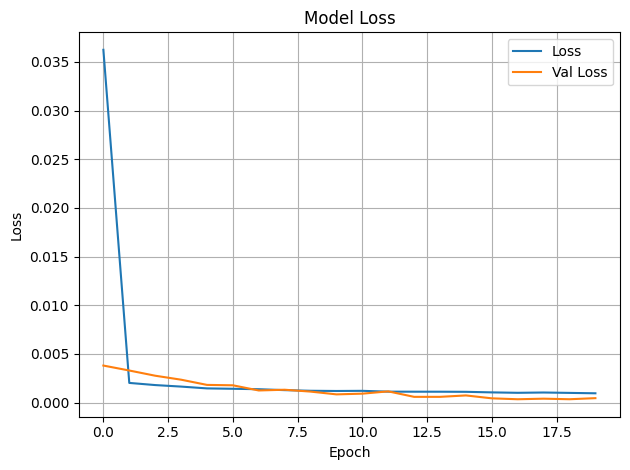

In [19]:
# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
#Training Set Prediction & Inverse Transform
yhat_train = model.predict(train_x)
train_x_2d = train_x.reshape((train_x.shape[0], train_x.shape[2]))
inv_yhat_train = np.concatenate((yhat_train, train_x_2d[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)[:, 0]

train_y_reshaped = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_y_reshaped, train_x_2d[:, 1:]), axis=1)
inv_y_train = np.concatenate((train_y_reshaped, train_x_2d[:, 1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)[:, 0]

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [21]:
#Testing Set Prediction & Inverse Transform
yhat_test = model.predict(test_x)
test_x_2d = test_x.reshape((test_x.shape[0], test_x.shape[2]))
inv_yhat_test = np.concatenate((yhat_test, test_x_2d[:, 1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)[:, 0]

test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y_test = np.concatenate((test_y_reshaped, test_x_2d[:, 1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)[:, 0]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [22]:
#Save Prediction
with open("train_predictions.pkl", "wb") as f:
    pickle.dump(inv_yhat_train, f)
with open("test_predictions.pkl", "wb") as f:
    pickle.dump(inv_yhat_test, f)

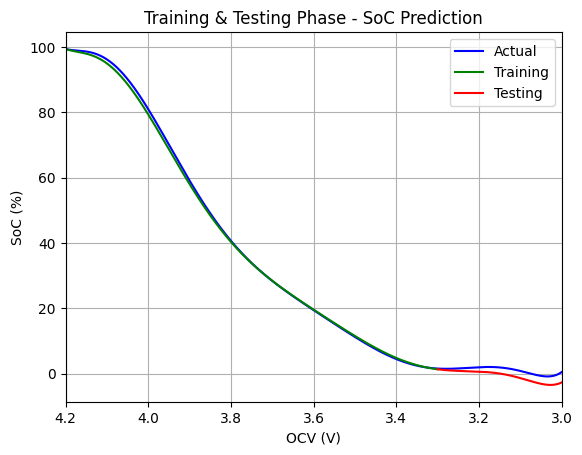

In [23]:
#Plotting Actual vs Prediction
x0 = list(range(len(train_y)))
x1 = list(range(len(train_y) + 1, len(train_y) + 1 + len(test_y)))
ydata = read_csv(file, usecols=[0], engine='python')

num_points = len(ydata)

ocv = np.linspace(4.2, 3.0, num_points)

x0 = list(range(len(train_y)))
x1 = list(range(len(train_y) + 1, len(train_y) + 1 + len(test_y)))

plt.figure(3)
plt.plot(ocv, ydata * 100, 'b', label='Actual')
plt.plot(ocv[:len(inv_yhat_train)], inv_yhat_train * 100, 'g', label='Training')
plt.plot(ocv[len(inv_yhat_train)+1:len(inv_yhat_train)+1+len(inv_yhat_test)], inv_yhat_test * 100, 'r', label='Testing')

plt.xlabel('OCV (V)')
plt.ylabel('SoC (%)')
plt.title('Training & Testing Phase - SoC Prediction')
plt.legend()
plt.grid(True)
plt.xlim(4.2, 3.0)
plt.show()

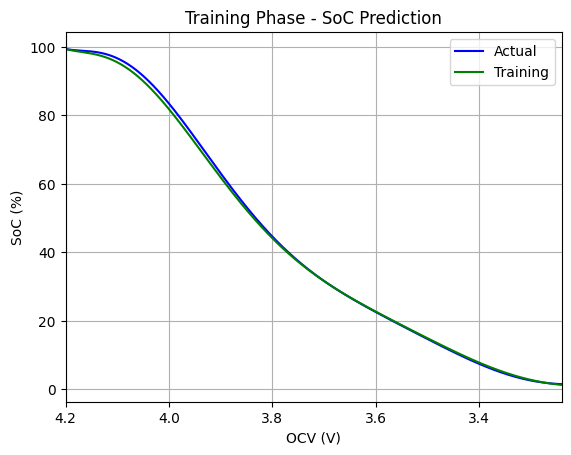

In [24]:
num_points = len(train_y)
vb = 4.2 - 0.8 * 1.2
ocv_train = np.linspace(4.2, vb, num_points)

plt.figure(4)
plt.plot(ocv_train, ydata[:num_points] * 100, 'b', label='Actual')
plt.plot(ocv_train, inv_yhat_train * 100, 'g', label='Training')
plt.xlabel('OCV (V)')
plt.ylabel('SoC (%)')
plt.title('Training Phase - SoC Prediction')
plt.legend()
plt.grid(True)
plt.xlim(4.2, vb)
plt.show()

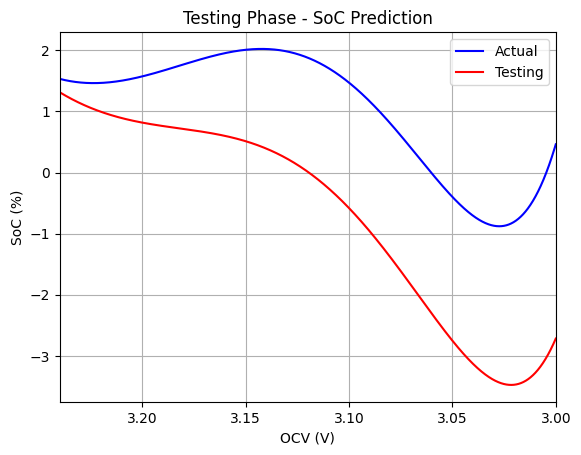

In [25]:
num_test = len(test_y)

ocv_test = np.linspace(vb, 3.0, num_test)

actual_test_soc = ydata[-num_test:] * 100

plt.figure(5)
plt.plot(ocv_test, actual_test_soc, 'b', label='Actual')
plt.plot(ocv_test, inv_yhat_test * 100, 'r', label='Testing')
plt.xlabel('OCV (V)')
plt.ylabel('SoC (%)')
plt.title('Testing Phase - SoC Prediction')
plt.legend()
plt.grid(True)
plt.xlim(vb, 3.0)
plt.show()

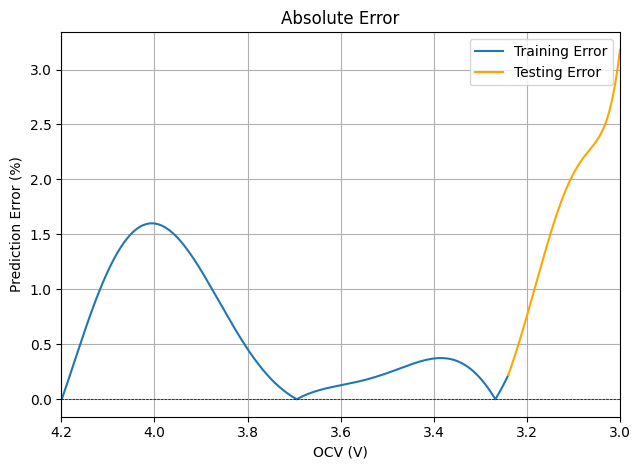

In [26]:
train_errors = np.abs(inv_y_train - inv_yhat_train) * 100
test_errors = np.abs(inv_y_test - inv_yhat_test) * 100

ocv_all = np.concatenate([ocv_train, ocv_test])
errors_all = np.concatenate([train_errors, test_errors])
labels_all = ['Training'] * len(train_errors) + ['Testing'] * len(test_errors)

plt.figure(6)
plt.plot(ocv_train, train_errors, label='Training Error', color='tab:blue')
plt.plot(ocv_test, test_errors, label='Testing Error', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.xlabel("OCV (V)")
plt.ylabel("Prediction Error (%)")
plt.title("Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(3.0, 4.2)
plt.gca().invert_xaxis()
plt.show()

In [27]:
# Nilai absolut dari Training dan Testing Error
print(f"Training Error: {np.mean(train_errors):.4f}%")
print(f"Testing Error: {np.mean(test_errors):.4f}%")

Training Error: 0.5695%
Testing Error: 1.7028%
